### Expectation-Maximization (EM) algorithm using MAP estimation 

Example notebook using the EM algorithm with MAP estimation to perform parameter recovery for a simple Bayesian Inference model (i.e., simulations, model fitting)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm, beta, gamma
from tqdm import tqdm

In [3]:
import sys
sys.path.append('../')
from pyEM.fitting import EMfit
from pyEM.math import norm2alpha, norm2beta, alpha2norm, beta2norm, compGauss_ms, calc_BICint, calc_LME, get_prior
from pyEM import plotting
import bayes_models

In [4]:
modelID = 'Bayes'
param_names = ['lambda']
objfunc_dict = {modelID: bayes_models.fit}
simul_dict   = {modelID: bayes_models.simulate}

nsubjects = 150
lambdamin, lambdamax = .34, .95

params = np.ones((nsubjects, 1))
for simS in tqdm(range(nsubjects)):

    # For lambda, we will sample from a normal distribution and then transform
    params[simS, ] = norm.rvs(loc=.6, scale=.2)
    while params[simS, ] > lambdamax or params[simS, ] < lambdamin:
        params[simS, ] = norm.rvs(loc=.6, scale=.2)

100%|██████████| 150/150 [00:00<00:00, 21445.46it/s]


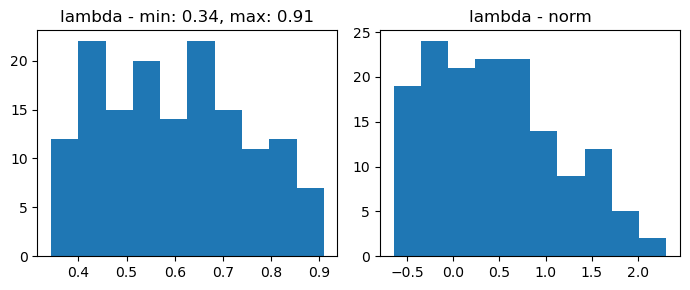

In [5]:
# plot 2 x 2
plt.figure(figsize=(7, 3))
plt.subplot(121)
plt.hist(params[:,0]);
plt.title(f'lambda - min: {min(params[:,0]):.2f}, max: {max(params[:,0]):.2f}');

plt.subplot(122)
plt.hist(alpha2norm(params[:,0]));
plt.title(f'lambda - norm');

plt.tight_layout()

In [6]:
ntrials, nblocks = 15, 10
simulfunc = simul_dict['Bayes']
subj_dict = simulfunc(params)

In [7]:
print(subj_dict.keys())

dict_keys(['params', 'choices', 'observations', 'probabilities', 'ponds'])


In [8]:
# create a list of lists with choices and rewards for each subject
all_data = []
for idx, (choices, observations) in enumerate(zip(subj_dict['choices'], subj_dict['observations'])):
    all_data += [[choices, observations]]

In [9]:
output_dict = EMfit(all_data, objfunc_dict['Bayes'], param_names, mstep_maxit=50, verbose=2)
m, inv_h, posterior, NPL, NLPrior, NLL, convergence = output_dict.values()

8064.154 (000), 7751.761 (001), 7730.438 (002), 7727.044 (003), 7726.234 (004), 7725.991 (005), 7725.905 (006), 7725.873 (007), 7725.862 (008), 7726.026 (009), 7725.906 (010), 7725.873 (011), 7725.860 (012), 7725.856 (013), 7725.855 (014),  -- CONVERGED!!!!!


In [10]:
modfit_dict = {}

# get covariance matrix
_, _, _, covmat_out = compGauss_ms(m,inv_h,2)
modfit_dict['covmat'] = covmat_out

# get LME and Hessian matrix
Laplace_approx, lme, goodHessian = calc_LME(inv_h, NPL)
modfit_dict['Laplace_approx'] = Laplace_approx
modfit_dict['lme'] = lme
modfit_dict['goodHessian'] = goodHessian

# get subjectwise model predictions
modfit_dict['est_params'] = m.T.copy()
modfit_dict['choices'] = np.zeros((nsubjects, nblocks, ntrials))
modfit_dict['observations'] = np.zeros((nsubjects, nblocks, ntrials))
modfit_dict['choice_probabilities'] = np.zeros((nsubjects, nblocks, ntrials+1, 3))
modfit_dict['choice_nll'] = np.zeros(nsubjects)

for subj_idx in range(nsubjects):

    # Get subjectwise model predictions
    choices = subj_dict['choices'][subj_idx,:,:]
    observations = subj_dict['observations'][subj_idx,:,:]
    model_fits = bayes_models.fit(m[:,subj_idx], choices, observations, prior=None, output='all')

    # store model fits
    modfit_dict['est_params'][subj_idx,:] = model_fits['params']
    modfit_dict['choices'][subj_idx,:,:] = model_fits['choices']
    modfit_dict['observations'][subj_idx,:,:] = model_fits['observations']
    modfit_dict['choice_probabilities'][subj_idx,:,:] = model_fits['choice_probabilities']
    modfit_dict['choice_nll'][subj_idx] = model_fits['choice_nll']

Good Hessians: 150 out of 150


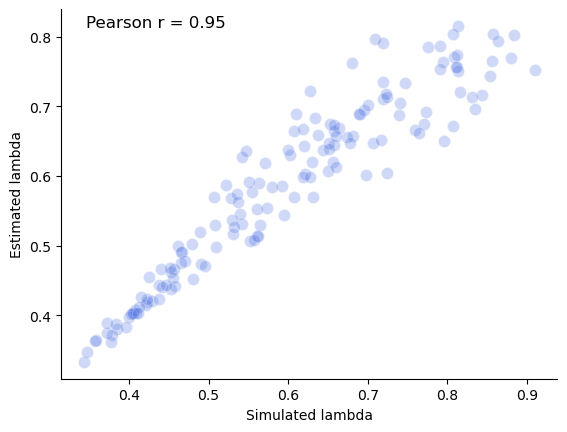

In [11]:
for param_idx, param_label in enumerate(param_names):
    simulated_param = subj_dict['params'][:,param_idx]
    fitted_params = modfit_dict['est_params'][:,param_idx]
    plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}')